In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import wandb
import xarray as xr

from functools import partial
from dask.diagnostics import ProgressBar

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker

import seaborn as sns

from fme_diags.utils import (
    get_run_kwargs, get_wandb_path,
    load_config, load_global_time_mean_metrics,
    melt_training_steps, open_autoregressive_inference, 
    open_reference,
)

_ = xr.set_options(keep_attrs=True)

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jamesd (ai2cm). Use `wandb login --relogin` to force relogin


True

In [2]:
FULL_RETRAINING = "42yrs-batch_size8-max_epochs50-lr3e-4-run4-ema"
FULL_FINETUNING = "fv3gfs_full_finetuning_lr3e-4_ep10-run00"
PART_FINETUNING = "fv3gfs_finetune_embed_enc_block7_dec_lr3e-4_ep10-run00"

ZERO_SHOT = "fv3gfs_zero_shot-run00"
REF = "42-years-training-set-reference"

TRAIN_RUN_LABELS = {
    FULL_RETRAINING: "Full retraining",
    FULL_FINETUNING: "Full\nfinetuning",
    PART_FINETUNING: "Partial\nfinetuning", 
}

RUN_LABELS = {
    **TRAIN_RUN_LABELS,
    ZERO_SHOT: "FV3GFS-to-EAMv2 zero shot",
    REF: "EAMv2 reference",
}

# FV3GFS = "retrain-30e-rs1-10yr-ema"

In [3]:
config = load_config("./preds.yaml")
run_kwargs = get_run_kwargs(config, FULL_RETRAINING)
ds = open_autoregressive_inference(**run_kwargs)

In [4]:
PRECIP = "surface_precipitation_rate"
PS = "PS"
OLR = "FLUT"
OSR = "top_of_atmos_upward_shortwave_flux"  
TWP_ADV = "tendency_of_total_water_path_due_to_advection"

PS_FACTOR = 0.01 
PS_UNITS = "hPa"

PRECIP_FACTOR = 86400.0
PRECIP_UNITS = "mm/day"

FLUX_UNITS = "W/m$^2$"

variables = config["variables"]
prognostic_vars = variables["labels"]["prognostic"]
diagnostic_vars = variables["labels"]["diagnostic"]
all_vars = {
    **prognostic_vars,
    **diagnostic_vars,
}

fv3gfs_variables = variables["fv3gfs"]
all_vars_fv3gfs = {
    **fv3gfs_variables["prognostic"],
    **fv3gfs_variables["diagnostic"],
}
fv3gfs_vars_dict = {v: all_vars[k] for k, v in all_vars_fv3gfs.items()}

wandb_inf_keys_stems = config["wandb_metrics"]["inference"]

all_units = {varname: ds[varname].units for varname in all_vars.keys()}
all_units[PRECIP] = PRECIP_UNITS
all_units[TWP_ADV] = PRECIP_UNITS
all_units[PS] = PS_UNITS

for k, v in all_units.items():
    if v == "W/m2":
        all_units[k] = FLUX_UNITS
        
all_units = pd.DataFrame.from_dict(all_units, orient="index", columns=["units"])

def rescale_variable(x, factor: float, units=None):
    x = x * factor
    if isinstance(x, xr.DataArray):
        x = x.assign_attrs(units=units)
    return x

UNIT_CONVERSIONS = {
    PRECIP: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    TWP_ADV: partial(rescale_variable, factor=PRECIP_FACTOR, units=PRECIP_UNITS),
    PS: partial(rescale_variable, factor=PS_FACTOR, units=PS_UNITS),
}

In [5]:
%%time

api = wandb.Api()

train_runs = {
    key: api.run(get_wandb_path(config, key, inference=False))
    for key in TRAIN_RUN_LABELS.keys()
}

train_rmse = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["rmse"],
        vars_dict=all_vars, 
        run_label=TRAIN_RUN_LABELS[key],
        apply_funcs=UNIT_CONVERSIONS,
    )
    for key, run in train_runs.items()
}

train_rmse_df = pd.concat(train_rmse.values())

CPU times: user 187 ms, sys: 23.9 ms, total: 211 ms
Wall time: 3.24 s


In [7]:
train_rmse_long = melt_training_steps(train_rmse_df)
train_rmse_long

value
run                 _step variable                                                
Full retraining     7665  PS                                             69.357979
                    15330 PS                                              7.292116
                    22995 PS                                              4.031606
                    30660 PS                                              4.814066
                    38325 PS                                              3.683984
...                                                                            ...
Partial\nfinetuning 45990 tendency_of_total_water_path_due_to_advection   0.514749
                    53655 tendency_of_total_water_path_due_to_advection   0.484078
                    61320 tendency_of_total_water_path_due_to_advection   0.523745
                    68985 tendency_of_total_water_path_due_to_advection   0.541353
                    76650 tendency_of_total_water_path_due_to_advection   0.506053

[3036 rows x 1 columns]

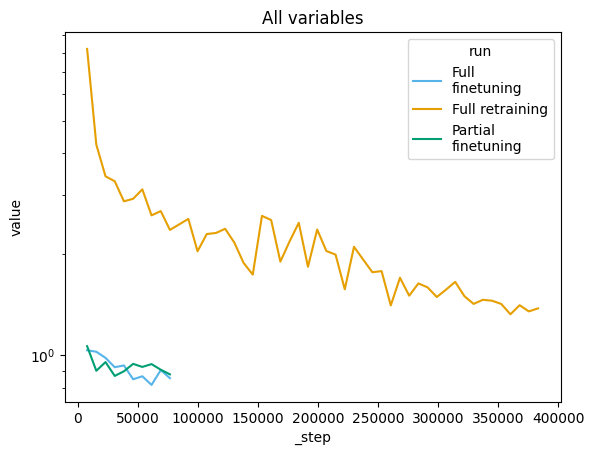

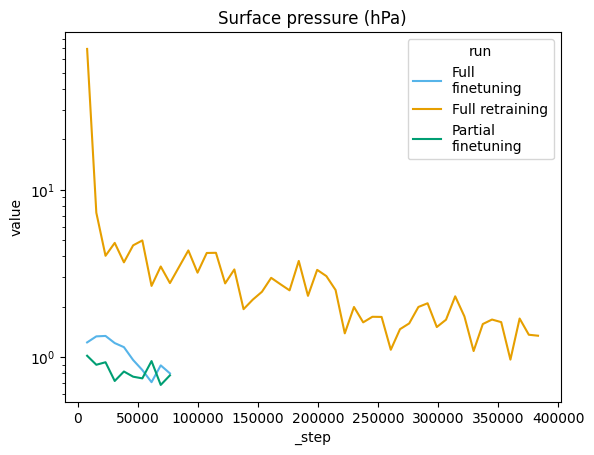

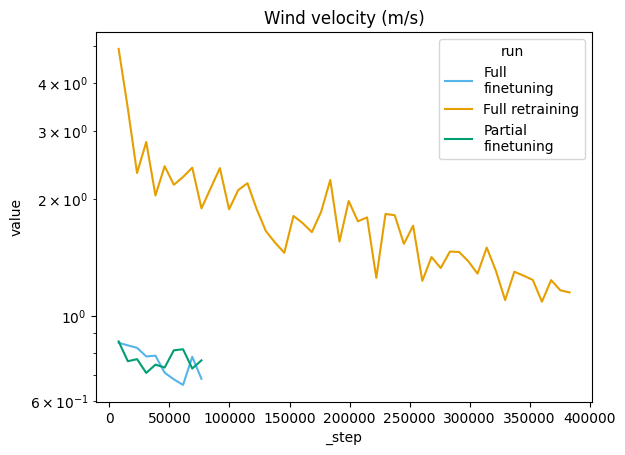

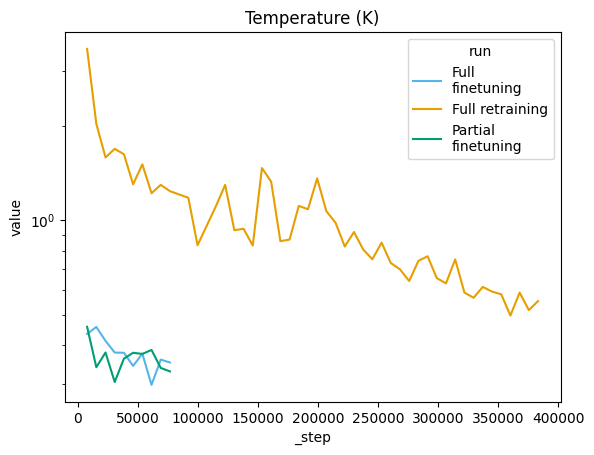

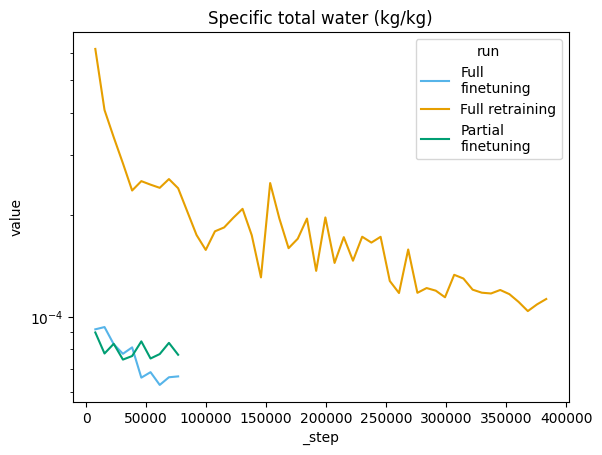

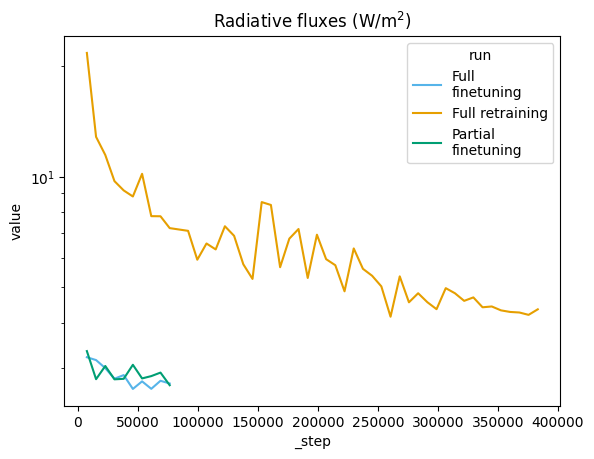

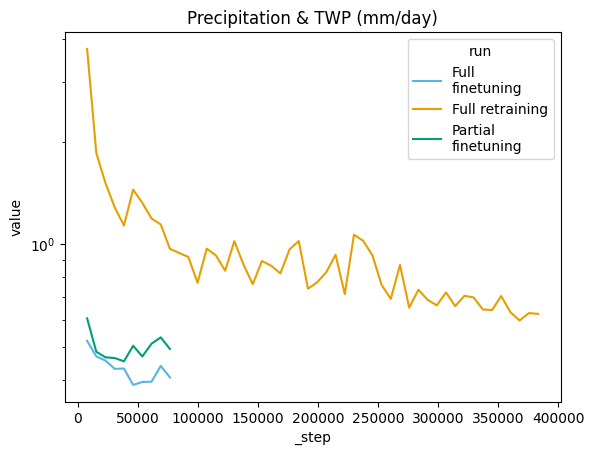

In [8]:
variable_groups = {
    "All variables": None,
    "Surface pressure (hPa)": ["PS"],
    "Wind velocity (m/s)": [f"U_{i}" for i in range(8)] + [f"V_{i}" for i in range(8)],
    "Temperature (K)": [f"T_{i}" for i in range(8)] + ["TS"],
    "Specific total water (kg/kg)": [f"specific_total_water_{i}" for i in range(8)],
    "Radiative fluxes (W/m$^2$)": [
        "top_of_atmos_upward_shortwave_flux", "FLUT", "FSDS",
        "FLDS", "surface_upward_shortwave_flux", "surface_upward_longwave_flux",
        "LHFLX", "SHFLX"
    ],
    "Precipitation & TWP (mm/day)": [
        "surface_precipitation_rate", "tendency_of_total_water_path_due_to_advection"
    ],
}

for title, group in variable_groups.items():
    if group is None:
        df = train_rmse_long
    else:
        df = train_rmse_long.reset_index("variable")
        df = df.loc[df["variable"].isin(group)]
        df = df.drop("variable", axis=1)
    df = df.groupby(["run", "_step"]).mean()
    
    g = sns.lineplot(
        data=df, 
        x="_step", y="value", hue="run"
    )
    g.set(yscale="log")
    
    plt.title(title)
    plt.show()

In [6]:
%%time

inf_runs = {
    key: api.run(get_wandb_path(config, key))
    for key in RUN_LABELS.keys()
}

inf_rmse = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["rmse"],
        vars_dict=all_vars, 
        run_label=RUN_LABELS[key],
        apply_funcs=UNIT_CONVERSIONS,
    )
    for key, run in inf_runs.items()
}

inf_rmse_df = pd.concat(inf_rmse.values())
inf_rmse_df

CPU times: user 65.8 ms, sys: 18.1 ms, total: 83.9 ms
Wall time: 4.23 s


,,PS,U_0,U_1,U_2,U_3,U_4,U_5,U_6,U_7,V_0,...,top_of_atmos_upward_shortwave_flux,FLUT,FSDS,FLDS,surface_upward_shortwave_flux,surface_upward_longwave_flux,LHFLX,SHFLX,surface_precipitation_rate,tendency_of_total_water_path_due_to_advection
run,_step,,,,,,,,,,,,,,,,,,,,,
Full retraining,14596,0.606210,1.253934,1.300621,1.416398,1.047343,0.733829,0.660278,0.562753,0.469792,0.311487,...,4.170425,2.828310,4.996842,1.845656,0.784294,1.080532,3.878033,1.465877,0.374055,0.396759
Full\nfinetuning,14596,0.883368,1.165382,0.691809,0.968879,0.801403,0.625961,0.565137,0.512834,0.407340,0.382892,...,4.347157,2.417391,5.828408,1.939102,1.213122,1.130205,4.079372,1.606813,0.397004,0.385190
Partial\nfinetuning,14596,0.886723,3.104101,1.331591,1.768065,1.068290,0.660595,0.645642,0.617050,0.464075,0.476365,...,4.062243,2.761692,4.871454,1.647400,1.191762,1.066515,4.253992,1.689301,0.470437,0.489221
FV3GFS-to-EAMv2 zero shot,14596,17.575348,5.981622,6.633701,7.320924,4.922740,3.049773,2.601016,2.670561,2.534203,1.383299,...,22.731043,15.100769,28.563524,24.877169,10.120887,10.519969,42.112568,9.993417,2.225351,2.053545
EAMv2 reference,14596,0.405713,0.477066,0.421827,0.579418,0.536041,0.425136,0.349129,0.302973,0.269928,0.229332,...,1.625972,1.246106,1.954883,0.884982,0.454033,0.611310,2.292200,1.044636,0.213610,0.221117


In [9]:
inf_rmse_long = melt_training_steps(inf_rmse_df)
inf_rmse_long

,,,value
run,_step,variable,
Full retraining,14596,PS,0.606210
Full\nfinetuning,14596,PS,0.883368
Partial\nfinetuning,14596,PS,0.886723
FV3GFS-to-EAMv2 zero shot,14596,PS,17.575348
EAMv2 reference,14596,PS,0.405713
...,...,...,...
Full retraining,14596,tendency_of_total_water_path_due_to_advection,0.396759
Full\nfinetuning,14596,tendency_of_total_water_path_due_to_advection,0.385190
Partial\nfinetuning,14596,tendency_of_total_water_path_due_to_advection,0.489221


In [13]:
inf_rmse_mean = {}

for title, group in variable_groups.items():
    if group is None:
        df = inf_rmse_long
    else:
        df = inf_rmse_long.reset_index("variable")
        df = df.loc[df["variable"].isin(group)]
        df = df.drop("variable", axis=1)
    df = df.reset_index("_step").drop("_step", axis=1)
    inf_rmse_mean[title] = df.groupby(["run"]).mean()
    
inf_rmse_mean["All variables"]

,value
run,
EAMv2 reference,0.407355
FV3GFS-to-EAMv2 zero shot,6.160847
Full\nfinetuning,0.816398
Full retraining,0.821708
Partial\nfinetuning,0.905766


In [15]:
%%time

inf_rmse_raw = {
    key: load_global_time_mean_metrics(
        wandb_run=run, 
        keys_stem=wandb_inf_keys_stems["rmse"],
        vars_dict=all_vars, 
        run_label=RUN_LABELS[key],
    )
    for key, run in inf_runs.items()
}

inf_rmse_raw_df = pd.concat(inf_rmse_raw.values())
inf_rmse_raw_long = melt_training_steps(inf_rmse_raw_df)

inf_rmse_raw_mean = {}

for title, group in variable_groups.items():
    if group is None:
        df = inf_rmse_raw_long
    else:
        df = inf_rmse_raw_long.reset_index("variable")
        df = df.loc[df["variable"].isin(group)]
        df = df.drop("variable", axis=1)
    df = df.reset_index("_step").drop("_step", axis=1)
    inf_rmse_raw_mean[title] = df.groupby(["run"]).mean()
    
inf_rmse_raw_mean["All variables"]

,value
run,
EAMv2 reference,1.310329
FV3GFS-to-EAMv2 zero shot,45.608133
Full\nfinetuning,2.786200
Full retraining,2.168162
Partial\nfinetuning,2.879083


In [18]:
inf_rmse_raw_long.loc["Full retraining"]

value
_step variable                                                   
14596 PS                                             6.062101e+01
      U_0                                            1.253934e+00
      U_1                                            1.300621e+00
      U_2                                            1.416398e+00
      U_3                                            1.047343e+00
      U_4                                            7.338293e-01
      U_5                                            6.602782e-01
      U_6                                            5.627533e-01
      U_7                                            4.697918e-01
      V_0                                            3.114873e-01
      V_1                                            3.608352e-01
      V_2                                            6.547610e-01
      V_3                                            5.556538e-01
      V_4                                            4.263293e-01
      V_5                                            3.484165e-01
      V_6                                            3.034967e-01
      V_7                                            3.128681e-01
      T_0                                            3.526881e-01
      T_1                                            4.843605e-01
      T_2                                            4.475622e-01
      T_3                                            3.927872e-01
      T_4                                            3.464432e-01
      T_5                                            2.742625e-01
      T_6                                            2.574641e-01
      T_7                                            2.243668e-01
      TS                                             2.288237e-01
      specific_total_water_0                         2.015362e-08
      specific_total_water_1                         1.097202e-07
      specific_total_water_2                         2.197858e-06
      specific_total_water_3                         3.347867e-05
      specific_total_water_4                         9.453481e-05
      specific_total_water_5                         1.556214e-04
      specific_total_water_6                         1.593928e-04
      specific_total_water_7                         1.504220e-04
      top_of_atmos_upward_shortwave_flux             4.170425e+00
      FLUT                                           2.828310e+00
      FSDS                                           4.996842e+00
      FLDS                                           1.845656e+00
      surface_upward_shortwave_flux                  7.842944e-01
      surface_upward_longwave_flux                   1.080532e+00
      LHFLX                                          3.878033e+00
      SHFLX                                          1.465877e+00
      surface_precipitation_rate                     4.329344e-06
      tendency_of_total_water_path_due_to_advection  4.592120e-06

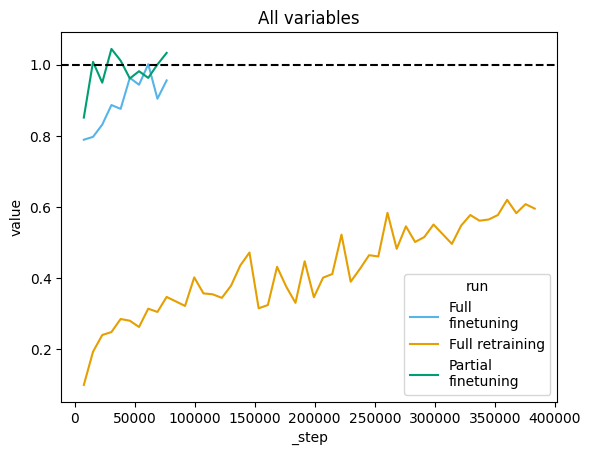

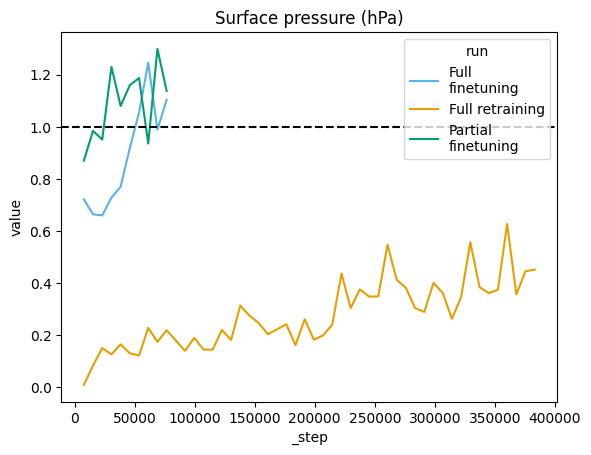

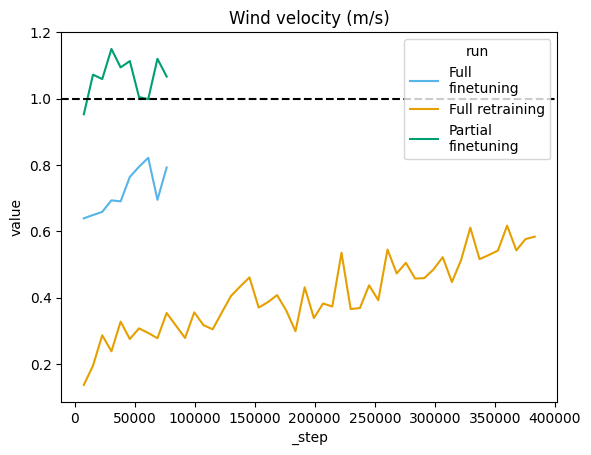

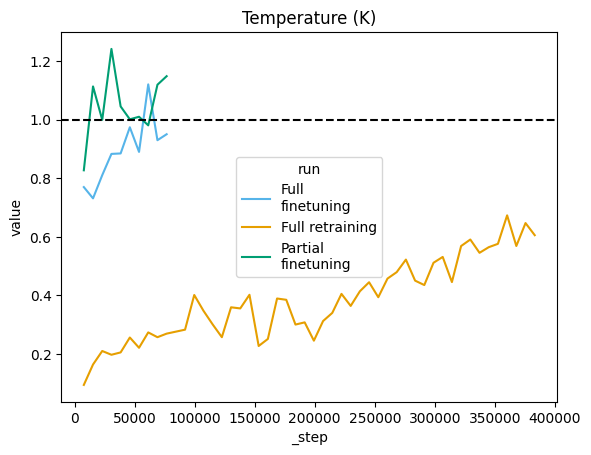

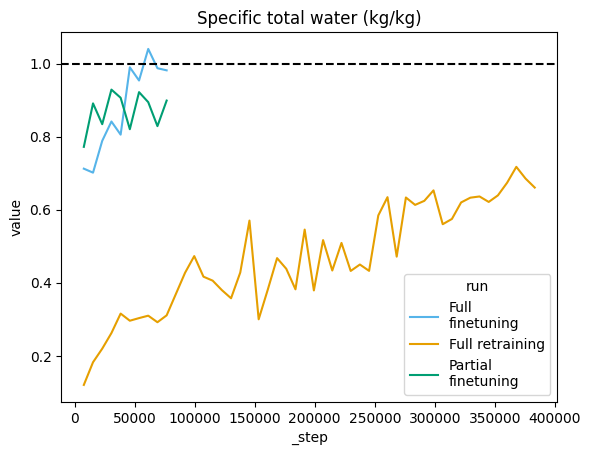

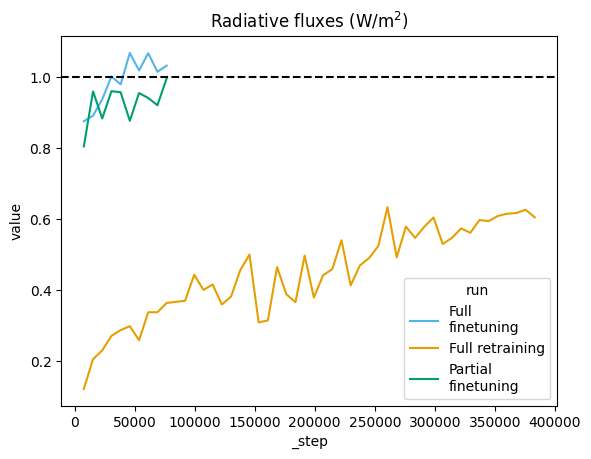

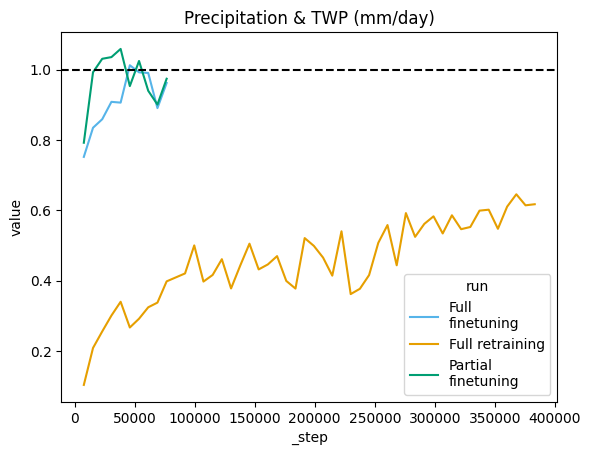

In [253]:
for title, group in variable_groups.items():
    if group is None:
        df = train_rmse_long
    else:
        df = train_rmse_long.reset_index("variable")
        df = df.loc[df["variable"].isin(group)]
        df = df.drop("variable", axis=1)
    df = df.groupby(["run", "_step"]).mean()
    
    df = df.join(
        inf_rmse_mean[title], 
        on="run", rsuffix="_inf"
    )
    # import pdb; pdb.set_trace()
    df["value"] = df["value_inf"] / df["value"]
    
    g = sns.lineplot(
        data=df, 
        x="_step", y="value", hue="run"
    )
    g.axhline(y=1.0, color="k", linestyle="--")
    # g.set(yscale="log")
    
    plt.title(title)
    plt.show()

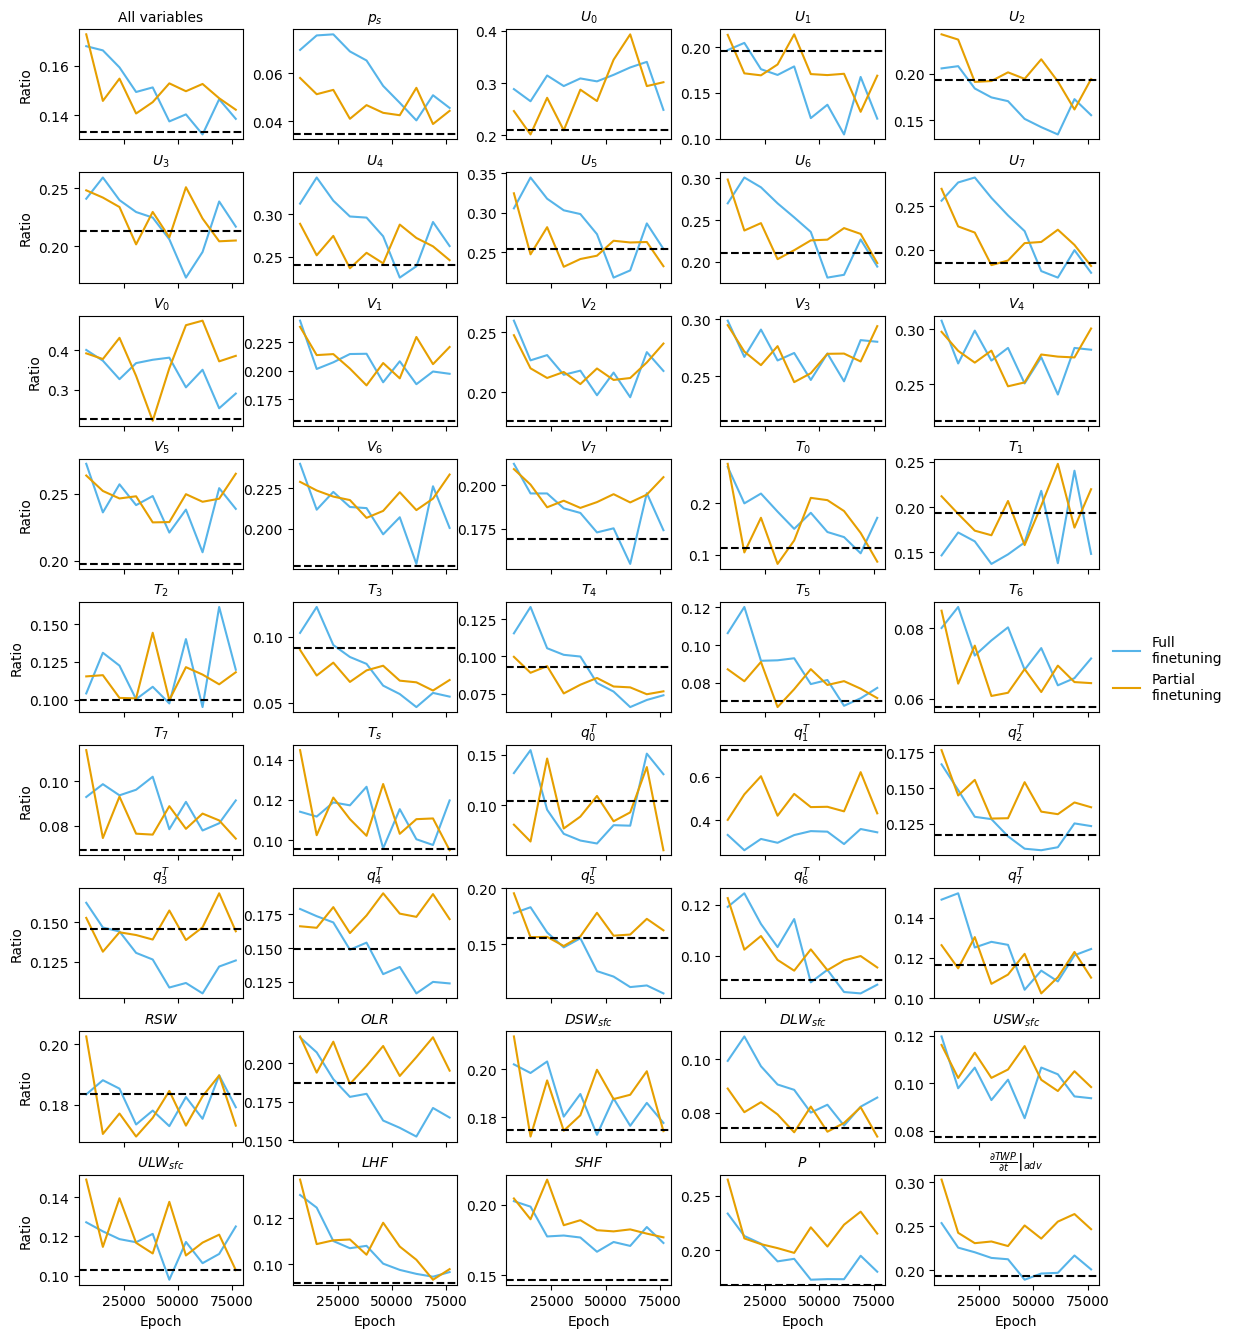

In [270]:
df_zero_shot_ratio = []
full_to_zero_ratios = {}

for variable, title in [(None, "All variables")] + list(all_vars.items()):
    if variable is None:
        df = train_rmse_long
        df_inf = inf_rmse_mean[title]
    else:
        df = train_rmse_long.reset_index("variable")
        df = df.loc[df["variable"] == variable]
        df = df.drop("variable", axis=1)
        df_inf = inf_rmse_long.reset_index(["variable", "_step"])
        df_inf = df_inf.loc[df_inf["variable"] == variable]
        df_inf = df_inf.drop(["variable", "_step"], axis=1)
    
    df = df.iloc[df.index.get_level_values(0) != "Full retraining"]
    
    df = df.groupby(["run", "_step"]).mean()
    
    # import pdb; pdb.set_trace()
    numer = df_inf.loc[RUN_LABELS[FULL_RETRAINING]].item()
    denom = df_inf.loc[RUN_LABELS[ZERO_SHOT]].item()
    
    full_to_zero_ratios[title] = numer / denom
    
    df["value"] = df["value"] / denom
    df["title"] = title
    df_zero_shot_ratio.append(df)
    
df_zero_shot_ratio = pd.concat(df_zero_shot_ratio)

g = sns.FacetGrid(
    df_zero_shot_ratio, col="title", col_wrap=5,
    margin_titles=True, despine=False,
    height=1.5, aspect=1.5, sharey=False,
)

# Map the line plots to each subplot
g.map_dataframe(sns.lineplot, x='_step', y='value', hue="run")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Epoch", "Ratio")

axs = g.axes.flatten()

for i, (title, value) in enumerate(full_to_zero_ratios.items()):
    axs[i].axhline(y=value, color="k", linestyle="--")

# g.set(yscale="log")

g.figure.subplots_adjust(wspace=0.3, hspace=0.3)
g.add_legend()

# plt.tight_layout()
plt.show()

# g = sns.lineplot(
#     data=df, 
#     x="_step", y="value", hue="run", col
# )

# plt.title(title)
# plt.show()

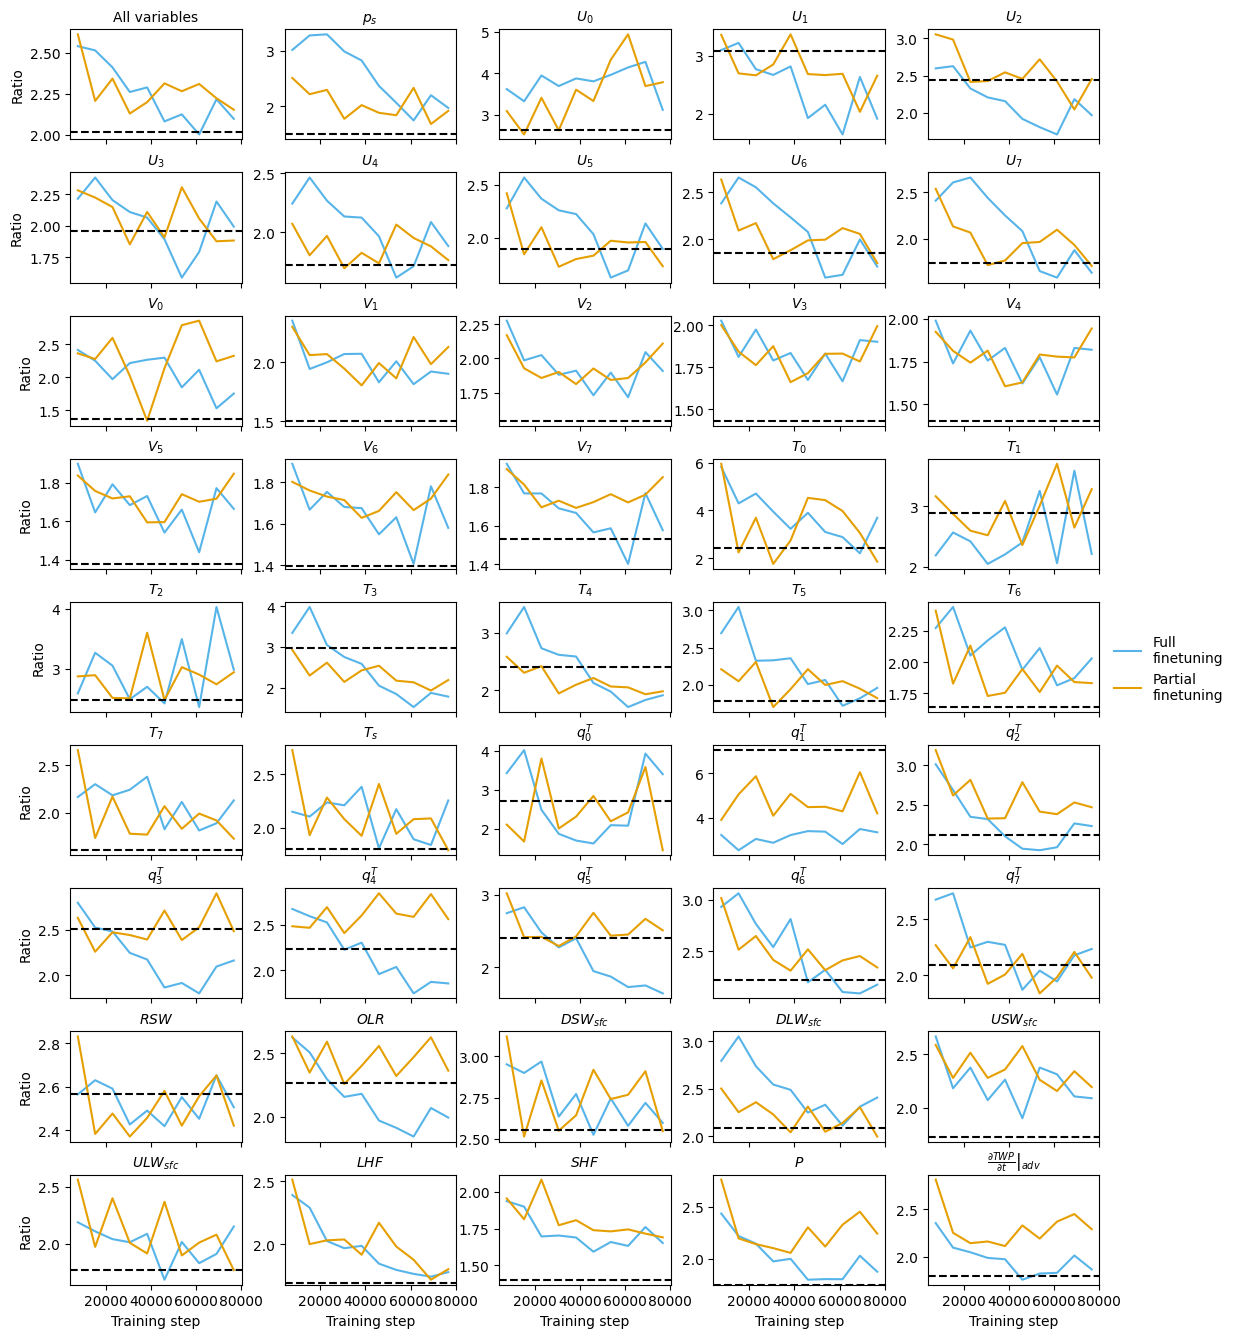

In [267]:
df_ref_ratio = []
full_to_ref_ratios = {}

for variable, title in [(None, "All variables")] + list(all_vars.items()):
    if variable is None:
        df = train_rmse_long
        df_inf = inf_rmse_mean[title]
    else:
        df = train_rmse_long.reset_index("variable")
        df = df.loc[df["variable"] == variable]
        df = df.drop("variable", axis=1)
        df_inf = inf_rmse_long.reset_index(["variable", "_step"])
        df_inf = df_inf.loc[df_inf["variable"] == variable]
        df_inf = df_inf.drop(["variable", "_step"], axis=1)
    
    df = df.iloc[df.index.get_level_values(0) != "Full retraining"]
    
    df = df.groupby(["run", "_step"]).mean()
    
    # import pdb; pdb.set_trace()
    numer = df_inf.loc[RUN_LABELS[FULL_RETRAINING]].item()
    denom = df_inf.loc[RUN_LABELS[REF]].item()
    
    full_to_ref_ratios[title] = numer / denom
    
    df["value"] = df["value"] / denom
    # new_index = pd.MultiIndex.from_arrays(
    #     [[title] * len(df), df.index.values], names=["title"] + df.index.names
    # )
    df["title"] = title
    # df = df.set_index("title", append=True)
    df_ref_ratio.append(df)
    
df_ref_ratio = pd.concat(df_ref_ratio)

g = sns.FacetGrid(
    df_ref_ratio, col="title", col_wrap=5,
    margin_titles=True, despine=False,
    height=1.5, aspect=1.5, sharey=False,
)

# Map the line plots to each subplot
g.map_dataframe(sns.lineplot, x='_step', y='value', hue="run")
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Training step", "Ratio")

axs = g.axes.flatten()

for i, (title, value) in enumerate(full_to_ref_ratios.items()):
    axs[i].axhline(y=value, color="k", linestyle="--")

# g.set(yscale="log")

g.figure.subplots_adjust(wspace=0.25, hspace=0.3)
g.add_legend()

# plt.tight_layout()
plt.show()

# g = sns.lineplot(
#     data=df, 
#     x="_step", y="value", hue="run", col
# )

# plt.title(title)
# plt.show()

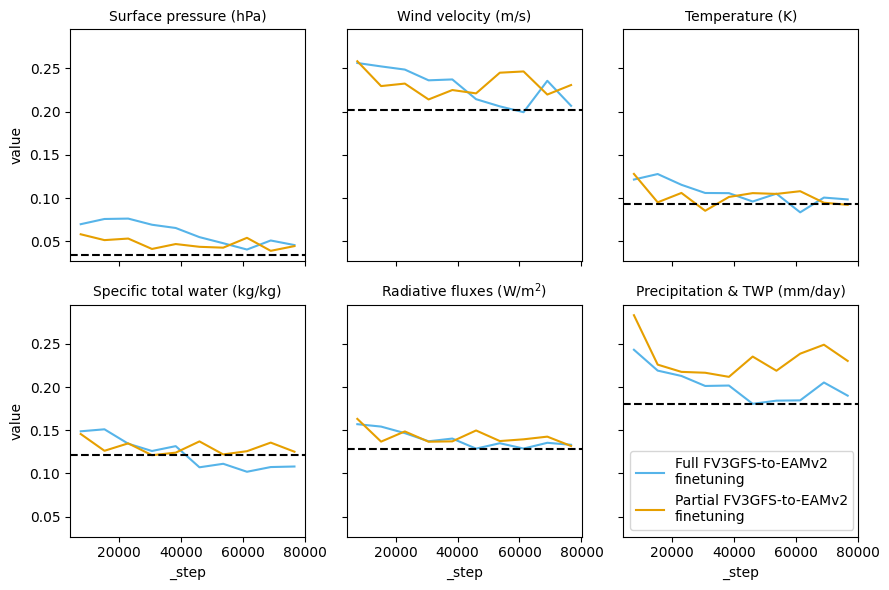

In [209]:
df_zero_shot_ratio = []
full_to_zero_ratios = {}

for title, group in variable_groups.items():
    if group is None:
        continue
        df = train_rmse_long
    else:
        df = train_rmse_long.reset_index("variable")
        df = df.loc[df["variable"].isin(group)]
        df = df.drop("variable", axis=1)
    
    df = df.iloc[df.index.get_level_values(0) != "Full retraining"]
    df = df.groupby(["run", "_step"]).mean()
    
    df_inf = inf_rmse_mean[title]
    numer = df_inf.loc[RUN_LABELS[FULL_RETRAINING]].item()
    denom = df_inf.loc[RUN_LABELS[ZERO_SHOT]].item()
    full_to_zero_ratios[title] = numer / denom
    
    df["value"] = df["value"] / denom
    # new_index = pd.MultiIndex.from_arrays(
    #     [[title] * len(df), df.index.values], names=["title"] + df.index.names
    # )
    df["title"] = title
    # df = df.set_index("title", append=True)
    df_zero_shot_ratio.append(df)
    
df_zero_shot_ratio = pd.concat(df_zero_shot_ratio)

g = sns.FacetGrid(
    df_zero_shot_ratio, col="title", col_wrap=3,
    margin_titles=True, despine=False,
    height=3,
)

# Map the line plots to each subplot
g.map_dataframe(sns.lineplot, x='_step', y='value', hue="run")
g.set_titles(col_template="{col_name}")
# g.figure.subplots_adjust(wspace=0, hspace=0)

axs = g.axes.flatten()

for i, (title, value) in enumerate(full_to_zero_ratios.items()):
    axs[i].axhline(y=value, color="k", linestyle="--")

# g.set(yscale="log")

plt.legend()
plt.show()

# g = sns.lineplot(
#     data=df, 
#     x="_step", y="value", hue="run", col
# )

# plt.title(title)
# plt.show()

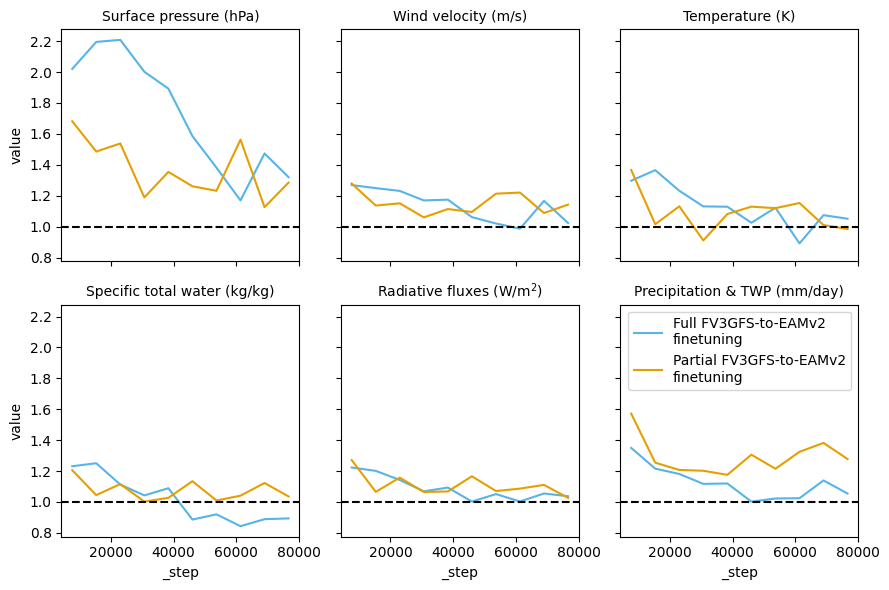

In [204]:
df_retraining_ratio = []

for title, group in variable_groups.items():
    if group is None:
        continue
        df = train_rmse_long
    else:
        df = train_rmse_long.reset_index("variable")
        df = df.loc[df["variable"].isin(group)]
        df = df.drop("variable", axis=1)
    
    df = df.iloc[df.index.get_level_values(0) != "Full retraining"]
    df = df.groupby(["run", "_step"]).mean()
    
    df_inf = inf_rmse_mean[title]
    denom = df_inf.loc[RUN_LABELS[FULL_RETRAINING]].item()
    df["value"] = df["value"] / denom
    df["title"] = title
    df_retraining_ratio.append(df)
    
df_retraining_ratio = pd.concat(df_retraining_ratio)

g = sns.FacetGrid(
    df_retraining_ratio, col="title", col_wrap=3,
    margin_titles=True, despine=False,
    height=3,
)

# Map the line plots to each subplot
g.map_dataframe(sns.lineplot, x='_step', y='value', hue="run")
g.set_titles(col_template="{col_name}")
# g.figure.subplots_adjust(wspace=0, hspace=0)

for ax in g.axes.flatten():
    ax.axhline(y=1.0, color="k", linestyle="--")
    
# g.set(yscale="log")

plt.legend()
plt.show()

# g = sns.lineplot(
#     data=df, 
#     x="_step", y="value", hue="run", col
# )

# plt.title(title)
# plt.show()

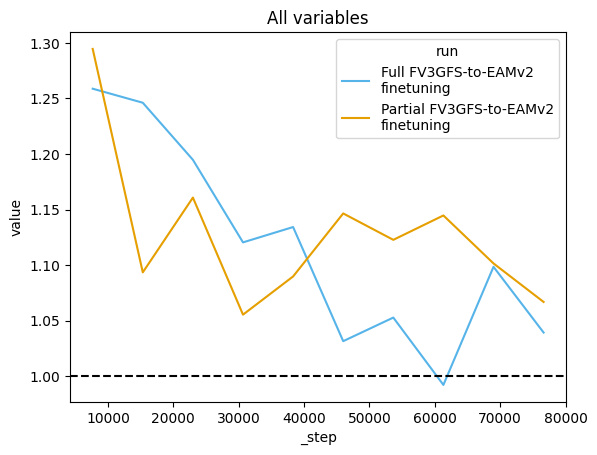

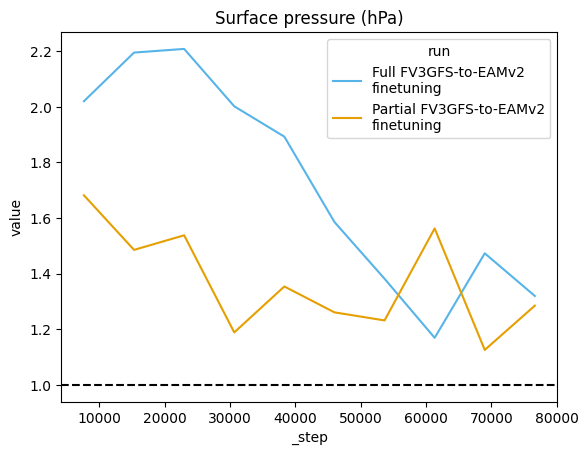

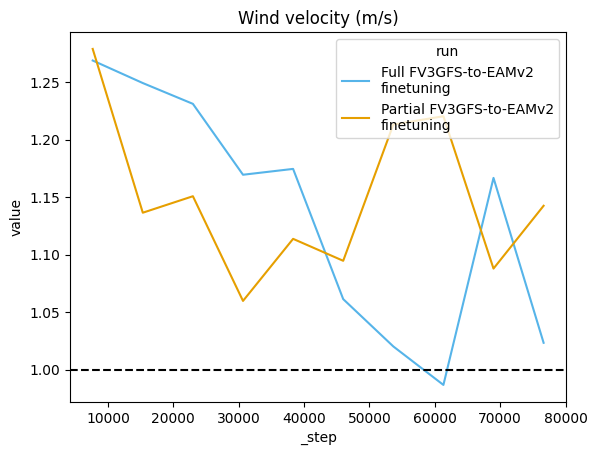

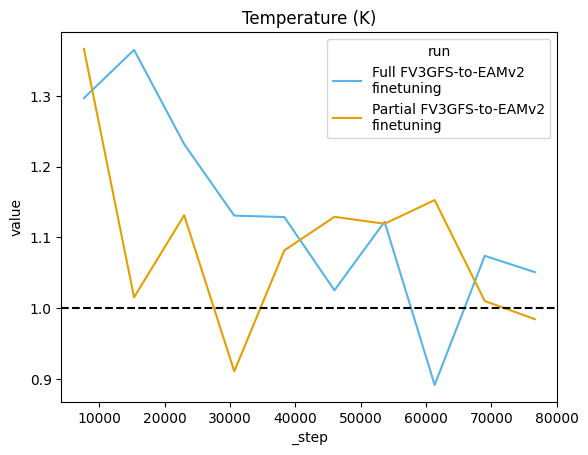

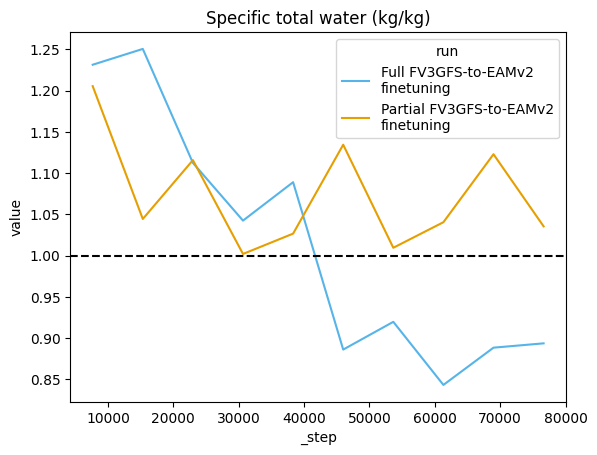

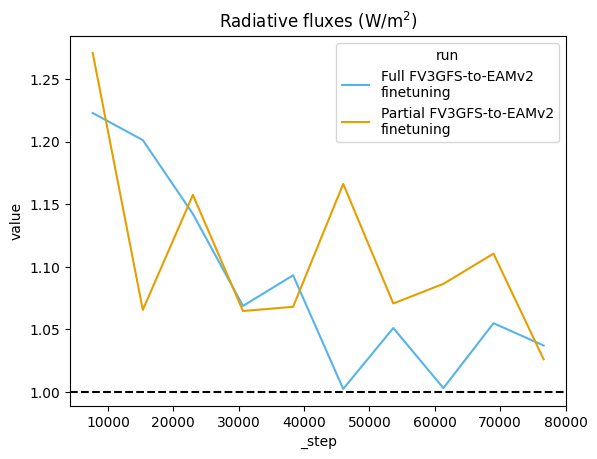

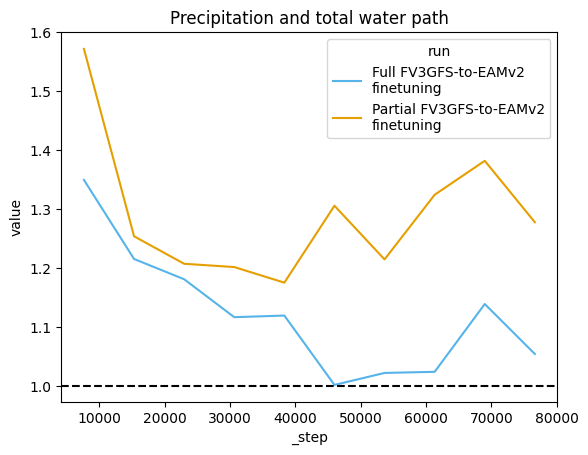

In [ ]:
for title, group in variable_groups.items():
    if group is None:
        df = train_rmse_long
    else:
        df = train_rmse_long.reset_index("variable")
        df = df.loc[df["variable"].isin(group)]
        df = df.drop("variable", axis=1)
    
    df = df.iloc[df.index.get_level_values(0) != "Full retraining"]
    df = df.groupby(["run", "_step"]).mean()
    # import pdb; pdb.set_trace()
    
    df_inf = inf_rmse_mean[title]
    denom = df_inf.loc[RUN_LABELS[FULL_RETRAINING]].item()
    df["value"] = df["value"] / denom
    
    g = sns.lineplot(
        data=df, 
        x="_step", y="value", hue="run"
    )
    g.axhline(y=1.0, color="k", linestyle="--")
    # g.set(yscale="log")
    
    plt.title(title)
    plt.show()

In [ ]:
inf_rmse_mean